<a href="https://colab.research.google.com/github/sjosephnyc1987/public_ipython_Notebooks/blob/main/DAL_STXE_TickData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prep**

our overall goal is as follows
1.Remove any Rows with Null Values
2.Remove a Lot that is 0 or Negative
3.Remove any instructions that are not 'Bid' or 'Ask;
4.Visually look at the chart (optional)
5.Remove any outliers that are outside of a 2 std deviation threshold 6.Remove any "cross market quotes"![level-2-chart.jpg](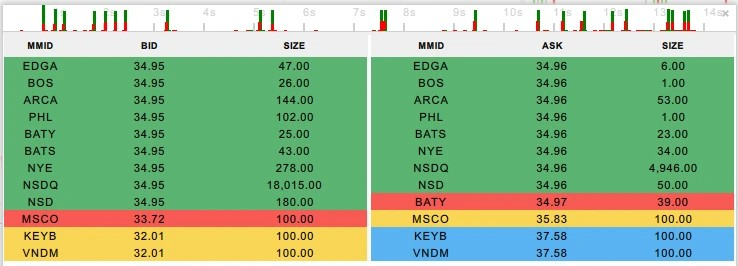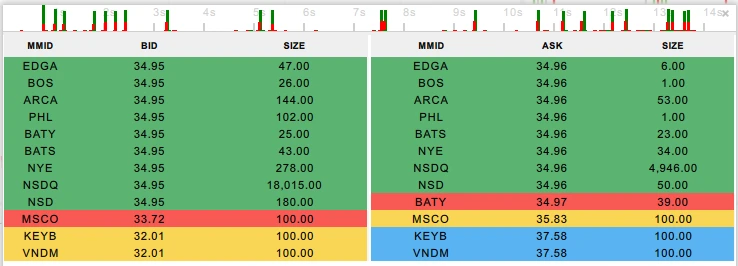) (Bid = Offer) in the same Timeframe
7.Remove any quotes where Bid > Offer 8.Remove Bid-Ask Bounce

In [2]:

#initializations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

#this is a terrible practice and dont do it
import warnings
warnings.filterwarnings("ignore")


Mounted at /content/drive


In [3]:
filepath = "/content/drive/MyDrive/TEMPO/datasets/STXE tick Data.csv"

df2 = pd.read_csv(filepath,sep='\t', header=0)

original_size = len(df2)
print("original dataframe size = ", original_size)

#Let's look at the first 10 rows
print(df2.head(10))

original dataframe size =  1566018
                    Id  Index   Type              TimestampUtc  Size  Value
0 -9223372020794013813      1  Trade  20160222 07:00:03.936984   738   2883
1 -9223372020794013812      2      O  20160222 07:00:03.936984     0   2883
2 -9223372020794013811      3      H  20160222 07:00:03.936984     0   2883
3 -9223372020794013810      4      L  20160222 07:00:03.936984     0   2883
4 -9223372020794013803      5    Bid  20160222 07:00:03.936984    20   2883
5 -9223372020794013802      6    Ask  20160222 07:00:03.936984    41   2884
6 -9223372020794013799      7  Trade  20160222 07:00:03.936984    10   2884
7 -9223372020794013797      8      H  20160222 07:00:03.936984     0   2884
8 -9223372020794013794      9    Ask  20160222 07:00:03.936984    31   2884
9 -9223372020794013790     10  Trade  20160222 07:00:03.936984     3   2884


In [4]:
#next let's see if there are any nulls and if so we should remove them
df2.isnull().sum()

Id              0
Index           0
Type            0
TimestampUtc    0
Size            0
Value           0
dtype: int64

In [5]:
#There appear to be some lots with Size of 0 and Negative, let's remove those and assign to a new dataframe df2_Size0_Removed
#as they appear to be artefacts
df2_Size0_Removed = df2[df2['Size']>0]

In [6]:
#Let's look at the first 10 rows again
print(df2_Size0_Removed.head(10))

                     Id  Index   Type              TimestampUtc  Size  Value
0  -9223372020794013813      1  Trade  20160222 07:00:03.936984   738   2883
4  -9223372020794013803      5    Bid  20160222 07:00:03.936984    20   2883
5  -9223372020794013802      6    Ask  20160222 07:00:03.936984    41   2884
6  -9223372020794013799      7  Trade  20160222 07:00:03.936984    10   2884
8  -9223372020794013794      9    Ask  20160222 07:00:03.936984    31   2884
9  -9223372020794013790     10  Trade  20160222 07:00:03.936984     3   2884
10 -9223372020794013787     11    Ask  20160222 07:00:03.936984    28   2884
11 -9223372020794013783     12  Trade  20160222 07:00:03.936984     1   2884
12 -9223372020794013781     13    Ask  20160222 07:00:03.936984    27   2884
13 -9223372020794013778     14  Trade  20160222 07:00:03.936984    27   2884


Entries of Index 2,3,4 and 8 from the first 10 rows had size 0, they seem to be gone and so we're on the right track

In [7]:
#we do a sanity check and look at the lenght of the dataframe now
print("current dataframe size = ", len(df2_Size0_Removed))
print("entries removed = ", original_size - len(df2_Size0_Removed))

current dataframe size =  1565954
entries removed =  64


In [8]:
#next we look for bad instruction types and remove them if needed
print(df2_Size0_Removed['Type'].value_counts())

Bid      765381
Ask      755135
Trade     45437
I             1
Name: Type, dtype: int64


We see a Type of "I" (and others) and so we remove them

In [9]:
df2_inst_Removed = df2_Size0_Removed[(df2_Size0_Removed['Type']=="Bid") | (df2_Size0_Removed['Type']=="Ask") | (df2_Size0_Removed['Type']=="Trade")]

In [10]:
#let's look at the lenght of the dataframe now
print(len(df2_inst_Removed))
print("--------")

#and the valuecounts again
print(df2_inst_Removed['Type'].value_counts())

1565953
--------
Bid      765381
Ask      755135
Trade     45437
Name: Type, dtype: int64


In [11]:
#for ease of handling we assign it to df3
df3 = df2_inst_Removed.copy()

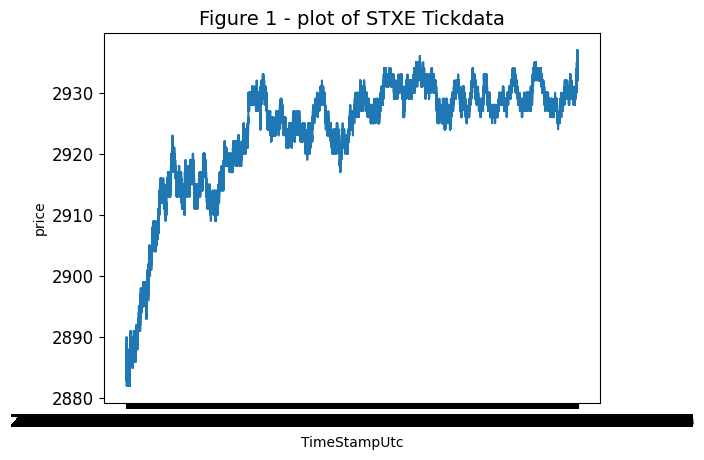

In [89]:
#Next we plot this data to get a visual impression

# Extract the date and close price columns
timestamp = df3['TimestampUtc']
price = df3['Value']

# Create a line plot
plt.plot(timestamp, price)
plt.xlabel("TimeStampUtc", fontsize=10)
plt.ylabel("price", fontsize=10)
plt.title(f"Figure 1 - plot of STXE Tickdata",fontsize =14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rcParams['figure.figsize'] = [25, 6]

plt.show()

We see some outliers, so we try an use a threshold to remove the data
**------------- tdl ----- add more here**

Although there is some overlap in Bid and Offer prices, not separating them will cause good quotes to drop out and so we separate the Bids, Asks and Trades before we do the comparison to the rolling media

In [12]:
#separating  the bids and offers
df3_bid = df3[df3['Type']=='Bid']
df3_ask = df3[df3['Type']=='Ask']
df3_trade = df3[df3['Type']=='Trade']

In [13]:
df3_bid['rolling_std_10']=df3_bid['Value'].rolling(10).std()
df3_ask['rolling_std_10']=df3_ask['Value'].rolling(10).std()
df3_trade['rolling_std_10']=df3_trade['Value'].rolling(10).std()

df3_bid['rolling_mean_10']=df3_bid['Value'].rolling(10).mean()
df3_ask['rolling_mean_10']=df3_ask['Value'].rolling(10).mean()
df3_trade['rolling_mean_10']=df3_trade['Value'].rolling(10).mean()

## **Filtering the data**
This only makes sense if there are more than 20 entries and so we do filter out outliers

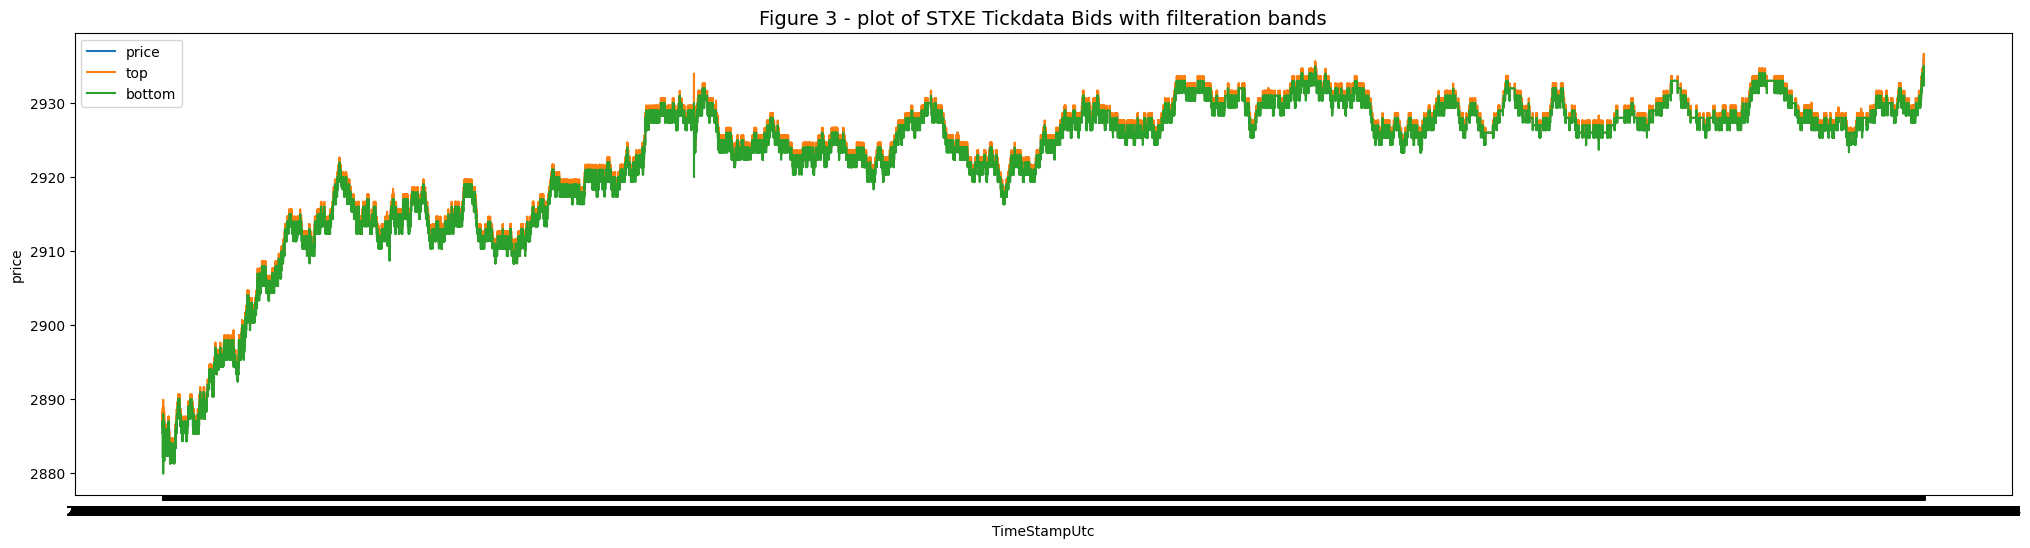

In [92]:
if len(df3_bid) > 20 :

    df3_bid['rolling_median_3']=df3_bid['Value'].rolling(3).median()
    df3_bid['rolling_mean_10']=df3_bid['Value'].rolling(10).mean()
    df3_bid['rolling_std_10']=df3_bid['Value'].rolling(10).std()

    df3_bid = df3_bid.dropna()

    df3_bid['topline'] = df3_bid['rolling_mean_10'] + 2*df3_bid['rolling_std_10']  #filter band top = Rolling means + 2 x Moving Std Deviation
    df3_bid['bottomline'] = df3_bid['rolling_mean_10'] - 2*df3_bid['rolling_std_10'] #filter band bottom = Rolling means - 2 x Moving Std Deviation
    df3_bid_filtered = df3_bid[df3_bid['Value'] <= df3_bid['topline']]
    df3_bid_filtered = df3_bid[df3_bid['Value'] > df3_bid['bottomline']]

    #let's plot the bids
    plt.plot(df3_bid['TimestampUtc'], df3_bid['Value'],label="price" )
    plt.plot(df3_bid['TimestampUtc'], df3_bid['topline'],label="top" )
    plt.plot(df3_bid['TimestampUtc'], df3_bid['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)
    plt.title(f"Figure 3 - plot of STXE Tickdata Bids with filteration bands",fontsize =14)
    plt.legend(loc="upper left")
    plt.rcParams['figure.figsize'] = [25, 6]

    plt.show()

else:
    df3_bid_filtered = df3_bid.copy()
    print("----not enough bids to filter------")  #debug


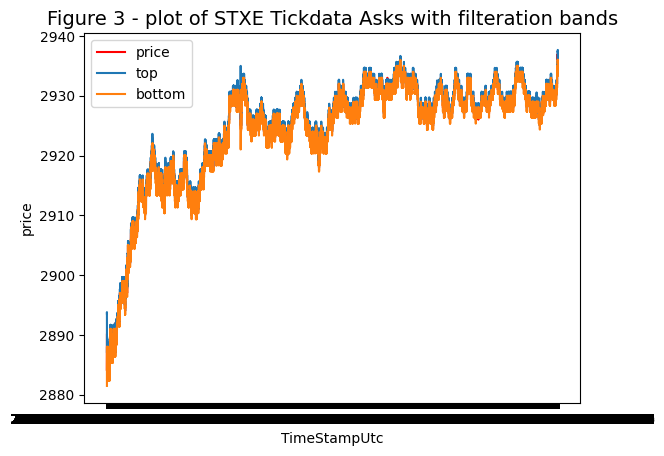

In [14]:
if len(df3_ask) > 20 :

    df3_ask['rolling_median_3']=df3_ask['Value'].rolling(3).median()
    df3_ask['rolling_mean_10']=df3_ask['Value'].rolling(10).mean()
    df3_ask['rolling_std_10']=df3_ask['Value'].rolling(10).std()

    df3_ask = df3_ask.dropna()

    df3_ask['topline'] = df3_ask['rolling_mean_10'] + 2*df3_ask['rolling_std_10']
    df3_ask['bottomline'] = df3_ask['rolling_mean_10'] - 2*df3_ask['rolling_std_10']
    df3_ask_filtered = df3_ask[df3_ask['Value'] <= df3_ask['topline']]
    df3_ask_filtered = df3_ask[df3_ask['Value'] > df3_ask['bottomline']]

    #let's plot the asks
    plt.plot(df3_ask['TimestampUtc'], df3_ask['Value'],label="price", color ='red' )
    plt.plot(df3_ask['TimestampUtc'], df3_ask['topline'],label="top" )
    plt.plot(df3_ask['TimestampUtc'], df3_ask['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)


    plt.title(f"Figure 3 - plot of STXE Tickdata Asks with filteration bands",fontsize =14)
    plt.legend(loc="upper left")
    plt.rcParams['figure.figsize'] = [25, 6]

    plt.show()

else:
    df3_ask_filtered = df3_ask.copy()
    print("----not enough asks to filter------")  #debug


Last we look at Trades

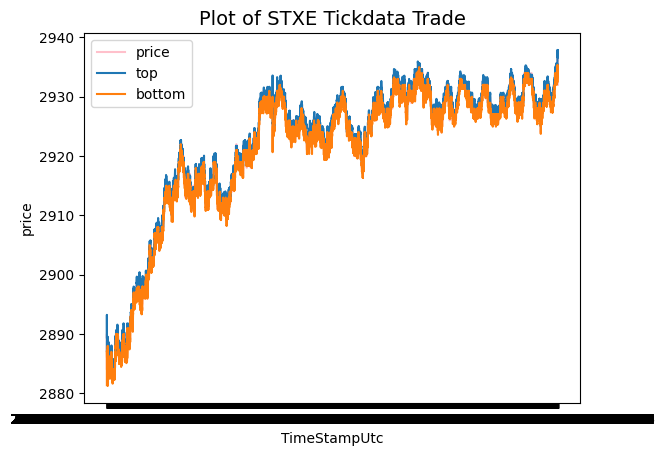

In [14]:
if len(df3_trade) > 20 :
    df3_trade['rolling_median_3']=df3_trade['Value'].rolling(3).median()
    df3_trade['rolling_mean_10']=df3_trade['Value'].rolling(10).mean()
    df3_trade['rolling_std_10']=df3_trade['Value'].rolling(10).std()

    df3_trade = df3_trade.dropna()

    df3_trade['topline'] = df3_trade['rolling_mean_10'] + 2*df3_trade['rolling_std_10']
    df3_trade['bottomline'] = df3_trade['rolling_mean_10'] - 2*df3_trade['rolling_std_10']
    df3_trade_filtered = df3_trade[df3_trade['Value'] <= df3_trade['topline']]
    df3_trade_filtered = df3_trade[df3_trade['Value'] > df3_trade['bottomline']]

    #let's plot the trades
    plt.plot(df3_trade['TimestampUtc'], df3_trade['Value'],label="price", color='pink' )
    plt.plot(df3_trade['TimestampUtc'], df3_trade['topline'],label="top" )
    plt.plot(df3_trade['TimestampUtc'], df3_trade['bottomline'],label="bottom" )
    plt.xlabel("TimeStampUtc", fontsize=10)
    plt.ylabel("price", fontsize=10)

    plt.title(f"Plot of STXE Tickdata Trade",fontsize =14)
    plt.legend(loc="upper left")

    plt.show()
else:
    df3_trade_filtered = df3_trade.copy()
    print("----not enough trades to filter------")  #debug

In [15]:
#unioning the two dataframes
df3_reunited = pd.concat([df3_bid_filtered,df3_ask_filtered, df3_trade_filtered])

#and bringing back the original sort
df3_final = df3_reunited.sort_values(by=['Index'])

#let's plot this again
plt.plot(df3_final['TimestampUtc'], df3_final['Value'],label="filtered data", color = 'green')

plt.xlabel("TimeStampUtc", fontsize=10)
plt.ylabel("price", fontsize=10)

plt.title(f"Figure 4 - plot of STXE Tickdata filtered data",fontsize =14)
plt.legend(loc="upper left")
plt.rcParams['figure.figsize'] = [25, 6]

plt.show()



NameError: name 'df3_bid_filtered' is not defined

## **Removing Cross / Locked market quotes**



In [ ]:
#First we remove trades from the data, so we're only looking at ticks
df4  = df3_final[df3_final['Type']!="Trade"]

#we subset the data into its relavant components
df5 = df4[['Index','TimestampUtc','Type','Value']]

#we pivot the data, by time and create columns for Bid and Offers
result = df5.assign(BID_PRICE=lambda df: df['Value'][df['Type'] == 'Bid'],
                     ASK_PRICE=lambda df: df['Value'][df['Type'] == 'Ask'])
#Let's look at this
print(result.head())

In [ ]:
#we aggregate the date by each instance of time and maximum bids and offers at that time
result_agg = result.groupby(['TimestampUtc']).agg({'BID_PRICE':'max','ASK_PRICE':'min'})
result_agg.rename(columns = {'BID_PRICE':'BID_MAX','ASK_PRICE':'ASK_MIN'}, inplace  = True)
print(result_agg.head(25).to_string())

In [ ]:
#We then calculate the spread (ASK_MAX minus BID_MAX) and discard the negative or zero values
result_agg['SPREAD'] = result_agg['ASK_MIN']-result_agg['BID_MAX']
res_sorted = result_agg.sort_values(by='SPREAD')

print(res_sorted.head(30))

There appears to be a ton of data with SPREAD <= 0 an so let's extract them

In [ ]:
#extracting rows where SPREAD <= 0
res_lockMkt_discards = res_sorted[res_sorted['SPREAD']<=0]

#Let's take a look at this data
print(res_lockMkt_discards.head(10).to_string())

In [ ]:
#We then extract the Timestamps into a list and use this to filter out the values we dont want
print(res_lockMkt_discards.index)
print("------------")
print(res_lockMkt_discards.index.to_frame())



print("------a------")
print(len(res_lockMkt_discards.index))
print("------b------")
print(len(df4))
print("------c------")
print(len(df4[~df4.TimestampUtc.isin(res_lockMkt_discards.index)]))
print("----ssss--------")
#type(res_lockMkt_discards_times)